# Reconocedor de lenguaje de señas Argentino entrenado solo con el dataset argentino.

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

Importamos los datasets y hacemos un split.
Comencemos por el dataset mas populado, el de lenguaje de señas americano, que utilizaremos para entrenar las capas intermedias.


In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Definimos los parametros
image_size = (299, 299)
batch_size = 32
asl_dir = "asl_dataset/"
train_val_seed = 42        # Es importante que sea la misma para ambos llamados

# Y creamos los conjuntos de entrenamiento y validacion. 
# Esto es medio raro, porque invocamos dos veces a image_dataset_from_directory para hacer el split,
# pero es la manera que indica la documentacion
asl_train_ds = image_dataset_from_directory(
    asl_dir,
    validation_split=0.2,
    subset="training",
    seed=train_val_seed, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'   # or 'categorical' if you want one-hot
)

asl_val_ds = image_dataset_from_directory(
    asl_dir,
    validation_split=0.2,
    subset="validation",
    seed=train_val_seed, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

class_names = asl_train_ds.class_names

Found 2515 files belonging to 36 classes.
Using 2012 files for training.
Found 2515 files belonging to 36 classes.
Using 503 files for validation.


In [7]:
print(class_names)

def count_elements(dataset):
    count = 0
    for batch in dataset:
        images, labels = batch
        count += images.shape[0]
    return count

print("Entradas en entrenamiento:", count_elements(asl_train_ds))
print("Entradas en validación:", count_elements(asl_val_ds))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Entradas en entrenamiento: 2012
Entradas en validación: 503


2025-08-01 19:44:47.120327: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Procesamos ahora las imagenes para adecuarlas al formato de *InceptionV3*,

In [8]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_img(image, label):
    image = preprocess_input(image) 
    return image, label

asl_train_ds = asl_train_ds.map(preprocess_img).prefetch(tf.data.AUTOTUNE)
asl_val_ds   = asl_val_ds.map(preprocess_img).prefetch(tf.data.AUTOTUNE)

Chequeemos que obtuvimos las clases correctas,

In [9]:
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Continuemos con la carga del dataset de lenguaje de señas argentino que definira las clases sobre la que predecirá el modelo.

In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Extraemos los nombres de todas las imagenes que vamos a utilizar
lsa_dir = 'lsa16_segmented/'
filenames = [f for f in os.listdir(lsa_dir)]

# Y de cada una extraemos su clase, que viene dada por el primer numero del nombre
labels = [int(f.split('_')[0]) - 1 for f in filenames]   # Le restamos 1 a los labels para que esten en rango [0, 16) en vez de [1, 16]

# Y creamos un dataframe que asocia a cada nombre de archivo su clase.
lsa_df = pd.DataFrame({'filename': filenames, 'class': labels})

Preprocesamos las imagenes para adecuarlas al formato de ImageNet

In [11]:
from sklearn.model_selection import train_test_split

# Separaramos el conjunto de test (20%)
lsa_temp_df, lsa_test_df = train_test_split(
    lsa_df,
    test_size=0.2,
    stratify=lsa_df['class'],
    random_state=42
)

# Y separamos lo restante en train y val (80% train -> 64% total, 20% val -> 16% total)
lsa_train_df, lsa_val_df = train_test_split(
    lsa_temp_df,
    test_size=0.2,  # 20% de 80% = 16% del total
    stratify=lsa_temp_df['class'],
    random_state=42
)

Creamos un *pipeline* de datos de *TensorFlow*. La idea es aprovechar la paralelización del *map* para procesar los datos mas rápido.

In [12]:
# Definimos una funcion que dado un filename devuelve su imagen y su clase o label
def load_and_preprocess(image_path, label):

    # Leemos el archivo y lo decodificamos en RGB
    img = tf.io.read_file(lsa_dir + image_path)
    img = tf.image.decode_jpeg(img, channels=3) 
    
    # Lo preprocesamos para InceptionV3
    img = tf.image.resize(img, [299, 299])
    img = preprocess_input(img)  # Obs. que preprocess_input es una funcion de inception_v3 en particular
    
    return img, label

# Usamos un batch_size de TensorFlow estandar
batch_size = 32

# 1. Cargamos el dataframe
lsa_ds = tf.data.Dataset.from_tensor_slices((lsa_train_df['filename'].values, lsa_train_df['class'].values))

# 2. Le mappeamos el preprocesamiento a cada entrada, paralelizando
lsa_ds = lsa_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# 3. Mezclamos para randomizar el orden de las muestras
lsa_ds = lsa_ds.shuffle(buffer_size=len(lsa_train_df))

# 4. Usamos el batch_size estandar
lsa_ds = lsa_ds.batch(batch_size)

# 5. Permitimos el prefetching del proximo batch
lsa_train_ds = lsa_ds.prefetch(tf.data.AUTOTUNE)                                                       

# Y repetimos lo mismo para el conjunto de validacion
lsa_val_ds = tf.data.Dataset.from_tensor_slices((lsa_val_df['filename'].values, lsa_val_df['class'].values))\
           .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
           .batch(batch_size) \
           .prefetch(tf.data.AUTOTUNE)

Entrenemos ahora las capas intermedias del modelo con el *dataset* de ASL,

Cargamos el modelo de manera que sea entrenable. No incluímos su última capa para poder establecer nuestras propias clases.

In [13]:
# Cargamos InceptionV3
base_model = InceptionV3(weights = 'imagenet',       # Pre-entrenado con ImageNet
                         include_top = False,        # Sin incluir su capa de clasificacion con 1000 clases para poder hacer fine-tuning 
                         input_shape = (299, 299, 3) # Necesario cuando no incluimos la ultima capa
                        )

# Inicialmente descongelamos todas las capas, despues congelamos las que no queremos que se entrenen
base_model.trainable = True

# Descongelamos desde la capa llamada mixed7, lo que descongela las ultimas ~50 capas.
set_trainable = False
for layer in base_model.layers:
    if layer.name == "mixed7":
        set_trainable = True
    layer.trainable = set_trainable

# Construimos la cabeza de clasificacion para las 36 clases de ASL
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(36, activation='softmax')(x)  # 26 letras + 10 digitos

model = Model(inputs=base_model.input, outputs=predictions)

# Compilamos el modelo usando un learning_rate bajo.
tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=tuning_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lo entrenamos con esos datos
model.fit(asl_train_ds, validation_data=asl_val_ds, epochs=1)

# Y nos guardamos los pesos del modelo del cual luego usaremos todo menos la cabeza de clasificacion.
model.save_weights("inceptionv3_hand_features.weights.h5")

2025-08-01 19:45:01.371149: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


 1/63 ━━━━━━━━━━━━━━━━━━━━ 14:33 14s/step - accuracy: 0.0000e+00 - loss: 3.8460

2025-08-01 19:45:03.883399: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


 2/63 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.0078 - loss: 3.8078      

2025-08-01 19:45:06.258399: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


 3/63 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.0122 - loss: 3.7905

2025-08-01 19:45:08.750826: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


 4/63 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.0130 - loss: 3.7822

2025-08-01 19:45:11.115742: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.1029 - loss: 3.4395 - val_accuracy: 0.1809 - val_loss: 3.2393


Ahora cargamos ese modelo que entrenamos pero le sacamos la cabeza y colocamos la clasificadora de LSA.

In [14]:
# Reconstruimos el modelo, nuevamente sin incluir el top.
base_model = InceptionV3(weights=None, include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Y en este caso freezamos todas las capas pues solo queremos entrenar la que agregaremos

# Le agregamos la ultima capa
num_classes = lsa_train_df['class'].nunique()

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Cargamos solo las capas compartidas con el modelo que entrenamos antes
model.load_weights("inceptionv3_hand_features.weights.h5", skip_mismatch=True)

# Lo compilamos, ahora con un learning rate un poco mas alto.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Y entrenamos
history = model.fit(lsa_train_ds, validation_data=lsa_val_ds, epochs=1)

/home/octavio/envs/asl_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:643: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense_3, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(1024, 16), Received: value.shape=(1024, 36). Target variable: <Variable path=dense_3/kernel, shape=(1024, 16), dtype=float32, value=[[-0.0205188   0.04112691  0.06684858 ... -0.05414442  0.06695524
  -0.06507482]
 [ 0.04626291 -0.02918088  0.02663457 ... -0.00343548  0.00574127
  -0.02905422]
 [-0.02177668 -0.00184821  0.01017255 ...  0.02207059 -0.04174433
  -0.02234919]
 ...
 [-0.00033433 -0.032683   -0.03942923 ... -0.01710185  0.05190751
  -0.05610539]
 [-0.0392981   0.03757297  0.0306303  ...  0.04533491  0.00957679
  -0.05994962]
 [-0.00791755  0.03439163  0.03149871 ... -0.02082872  0.04544543
  -0.03792374]]>

List of objects that could not be lo

16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1777 - loss: 2.8009 - val_accuracy: 0.4219 - val_loss: 1.7348


Y guardamos los pesos de este modelo final,

In [15]:
model.save_weights("combined_interpreter_final.weights.h5")

Veamos ahora los grafiquitos

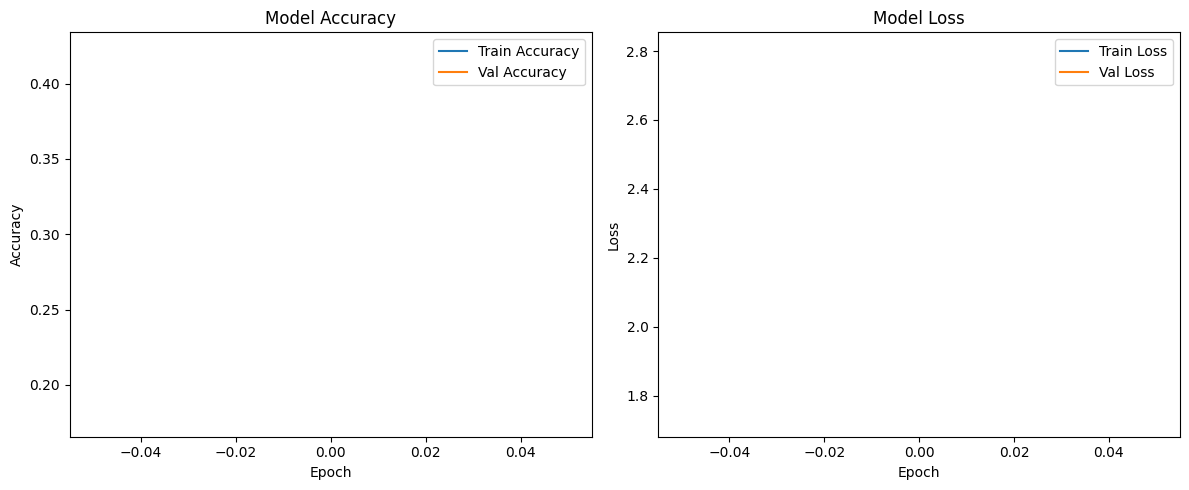

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Esto que sigue creo que no funciona.

In [17]:
img_path = 'lsa16_segmented/1_1_1.png'  
img = image.load_img(img_path, target_size=(299, 299)) # La carga en img y le hace resize a 299x299
img_array = image.img_to_array(img)                    # La convierte a array de NumPy con dimensiones (299, 299, 3)
img_array = np.expand_dims(img_array, axis=0)          # Agrega una dimension mas al array, haciendolo (1, 299, 299, 3) para batching
img_array = preprocess_input(img_array)                # Matchea la representacion de la imagen a como la espera ImageNet (ej. mappea 0-255 a -1,1, cambia de RGB a BGR)

# Predict
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=5)[0]

# Display results
plt.imshow(img)
plt.axis('off')
plt.show()

print("Top 5 Predictions:")
for i, (_, label, prob) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({prob * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (1, 16)